In [1]:
!pip install pandas pandas-ta

In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np

In [3]:
history = pd.read_csv('./AMZN.csv')

In [4]:
# Reverse dataframe to sort prices by date, ascending order
history = history.iloc[::-1]
history = history.reset_index(drop=True)
#history = history.iloc[365:730]
history = history.iloc[0:365]
history = history.reset_index(drop=True)

In [5]:
history

,Date,Close,Volume,Open,High,Low
0,08/16/2013,14.2410,48396380,14.3275,14.4165,14.2250
1,08/19/2013,14.2785,49548580,14.2595,14.4780,14.1740
2,08/20/2013,14.3545,31705200,14.2940,14.4758,14.2870
3,08/21/2013,14.2285,36301420,14.2545,14.4250,14.1915
4,08/22/2013,14.4865,28451720,14.2400,14.4935,14.2400
...,...,...,...,...,...,...
360,01/22/2015,15.5160,106770600,15.0000,15.6125,15.0000
361,01/23/2015,15.6195,89520900,15.4040,15.8465,15.3860
362,01/26/2015,15.4830,63376540,15.5910,15.6500,15.3760
363,01/27/2015,15.3375,58354200,15.3150,15.5122,15.1313


In [6]:
WINDOW_SIZE = 2

# Initial window/preliminary data
df = history.iloc[0:WINDOW_SIZE]

In [7]:
def compute_indicators(df):
    df = df.copy()

    def get_indicator():
        n = 15 #rolling period
        lmins = df.loc[df['Close'] == df['Close'].rolling(n, center=True).min(), 'Close']
        return lmins

    #df.loc[:, "LMINS"] = get_indicator()
    
    return df

def update_and_recalculate(df, series_index):
    # Get new update to include in frame
    new_data = history.iloc[series_index].copy()

    # Insert row in frame
    df.loc[len(df)] = new_data

    # Compute TA
    return compute_indicators(df)

In [8]:
df = compute_indicators(df)

In [9]:
df

,Date,Close,Volume,Open,High,Low
0,08/16/2013,14.2410,48396380,14.3275,14.4165,14.225
1,08/19/2013,14.2785,49548580,14.2595,14.4780,14.174


In [10]:
window = df.loc[0:1,['Date','Close']].to_numpy()
window

array([['08/16/2013', 14.241],
       ['08/19/2013', 14.2785]], dtype=object)

In [11]:
from strategy_lmins import LMinsBot as Bot
from utils import BotTracker

# Start iterating over the history data. simulates that we gather price data from an external provider
# at every new step/iteration, we add the price data into the dataframe df and recompute TAs
# then we move the window 1 day forward and only pass into the bot that window

start_index = 0

t = BotTracker(start_index + WINDOW_SIZE - 1)
b = Bot(money=5000, events_listener=t)
print(f"Initial money: {b.budget()}")

def compute_lmins(df, n=15):
    #n = 15 #rolling period
    lmins = df.loc[df['Close'] == df['Close'].rolling(n, center=True).min(), 'Close']
    return lmins

while start_index < len(history)-WINDOW_SIZE+1:
    df = update_and_recalculate(df, start_index+WINDOW_SIZE-1)
    window = df.loc[start_index:start_index+WINDOW_SIZE-1,['Date','Close']].to_numpy()
    
    lmins = compute_lmins(df)
    lmins = lmins.loc[start_index-90:start_index]
    
    b.think(window, lmins.to_numpy())
    if start_index % 100 == 0:
        print(f"Checkpoint at {start_index}, money: {b.budget()}")
    
    start_index += 1
    t.incr()

date, price = df.loc[(len(df)-1), ['Date', 'Close']]
b.finish(date, price)
print(f"Money at the end: {b.budget()}")
    

Initial money: 5000
Checkpoint at 0, money: 5000
Checkpoint at 100, money: 5000
Closed position, earned: -10%
Closed position, earned: -9%
Closed position, earned: -10%
Closed position, earned: -9%
Closed position, earned: -6%
Closed position, earned: -7%
Closed position, earned: -8%
Closed position, earned: -7%
Closed position, earned: -6%
Closed position, earned: -6%
Closed position, earned: -6%
Closed position, earned: -5%
Closed position, earned: -5%
Checkpoint at 200, money: 1006.9186133303454
Closed position, earned: 7%
Closed position, earned: 9%
Closed position, earned: 4%
Closed position, earned: 5%
Closed position, earned: -5%
Closed position, earned: -5%
Closed position, earned: -5%
Closed position, earned: -5%
Closed position, earned: -5%
Closed position, earned: -5%
Closed position, earned: -6%
Closed position, earned: -5%
Closed position, earned: -5%
Closed position, earned: -6%
Closed position, earned: -8%
Closed position, earned: -10%
Closed position, earned: -6%
Closed

[(14.046499999999993, 86), (14.900933333333333, 75), (17.26768, 175), (19.0625, 62), (19.611048076923076, 104), (15.440421487603308, 121), (14.3977803030303, 66), (16.19981451612903, 62)]


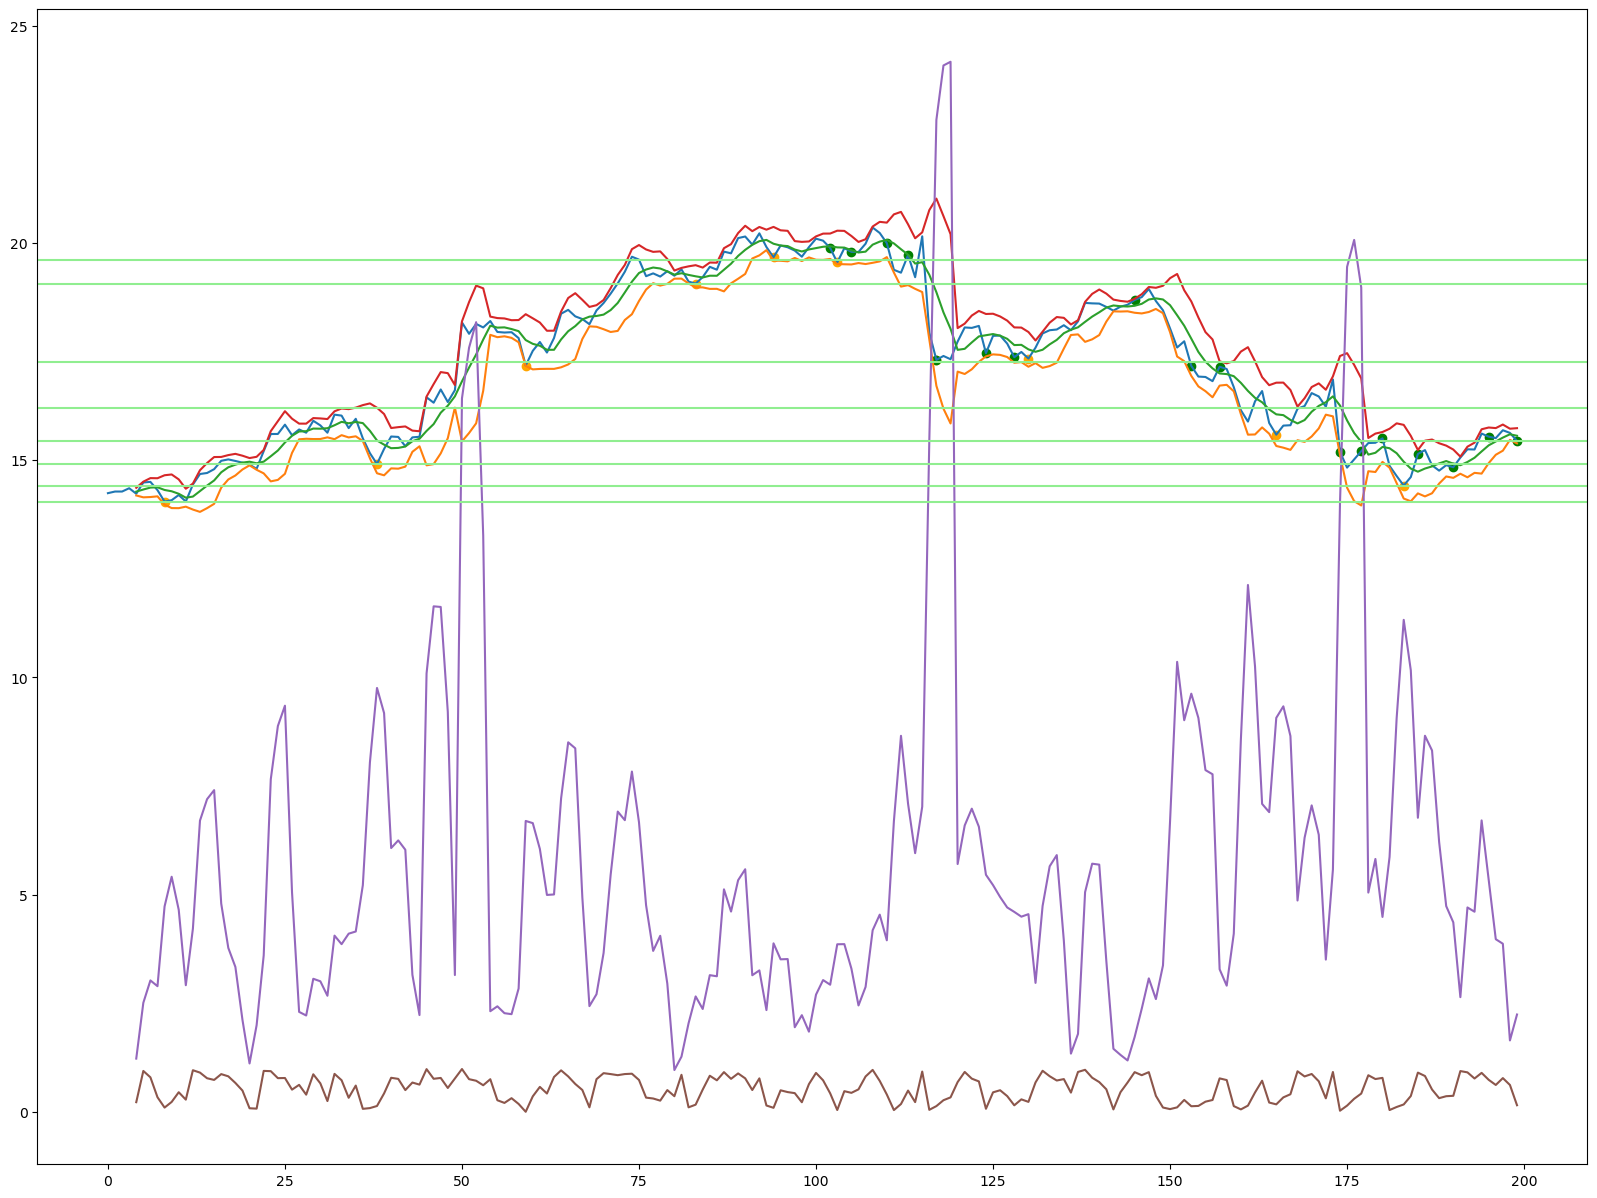

In [38]:
import matplotlib.pyplot as plt

S=0
E=200
#tsignals = ta.adx(df['High'], df['Low'], df['Close']).to_numpy()

prices = df['Close'].to_numpy()
mins = compute_lmins(df, 15)
mins = mins.loc[S:E]

bb = ta.bbands(df['Close'])

plt.figure(figsize=(20, 15))
plt.plot(prices[S:E])

bb[0:E-S] = bb[S:E]
plt.plot(bb[0:E-S])

for k in mins.keys():
    plt.scatter(k-S, mins[k], color="orange")


opened_positions_data = t.get_for_rendering()
for p in opened_positions_data:
    if p["index"] < S or p["index"] > E:
        continue
    #plt.axvline(x=p["index"]-S, color='green')
    plt.scatter(p["index"]-S, p["price"], color="green")

l_groups = b.get_groups()
print(l_groups)
for g in l_groups:
    y,_ = g
    plt.axhline(y=y, color="lightgreen")

In [29]:


for k in mins.keys():
    print(f'{k} ==>> {mins[k]}')

mins.loc[100:200]


8 ==>> 14.0465
38 ==>> 14.9115
59 ==>> 17.178
83 ==>> 19.0625
94 ==>> 19.6685
103 ==>> 19.549
117 ==>> 17.3075
130 ==>> 17.338
165 ==>> 15.5865
183 ==>> 14.416
201 ==>> 15.339
215 ==>> 16.208
224 ==>> 16.1905
242 ==>> 15.353
301 ==>> 14.353
337 ==>> 14.753
357 ==>> 14.3475


103    19.5490
117    17.3075
130    17.3380
165    15.5865
183    14.4160
Name: Close, dtype: float64